# 1 - Open Exploration

## 1.1. Exploratory Analysis

In this section, we apply scenario discovery to identify the uncertainty space. Our aim is to maximize the minimum water level in the system. 
We will use Problem formulation 2. We have previously added the Minimum Water Level as an outcome in [Problem Formulation](problem_formulation.py) by adding the function min_over_pf2.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns

from ema_workbench import MultiprocessingEvaluator
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench import load_results



In [19]:
# Importing EMA workbench
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

### Business as Usual Analysis: Global sensitivity using SOBOL- Celia

Check what are the most uncertain parameters in the status quo, especial focus on the Minimum water level outcome. 
We will focus afterwards on these parameters

### Random policies - Celia
First, we explore the lever space by sampling random lever combinations (policies)

We are agoing to address the worst possible combinations, so our client can avoid them. We do this to have a first picture.

We have to keep in mind that some combinations may be absurd, (RfR in 2020 On and RfR in 2025 off, nonsense)

Output: Worst case scenarios that make sense

In [20]:
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time


dike_model, planning_steps = get_model_for_problem_formulation(2)

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [21]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Minimum Water Level', variable_name=('A.1_Water Level', 'A.2_Water Level', 'A.3_Water Level', 'A.4_Water Level', 'A.5_Water Level'), function=<function min_over_pf2 at 0x125a3fa60>)
ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x125a3f880>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_

In [46]:
# ---Run  experiments with random combination of levers and plot results---


ema_logging.log_to_stderr(ema_logging.INFO)

scenarios = 100
policies = 10

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios, policies)

experiments, outcomes = results


[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 100 scenarios * 10 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:10<00:00, 93.26it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [47]:
experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                       int64
0_RfR 1                       int64
0_RfR 2                       int64
1_RfR 0                       int64
1_RfR 1                       int64
1_RfR 2                       int64
2_RfR 0                       int64
2_RfR 1                       int64
2_RfR 2                     

In [48]:
#RfR should be 0 or 1, so we can convert it to boolean
for col in experiments.columns:
    if 'RfR' in col:
        experiments[col] = experiments[col].astype(bool)

# Dike heightening should float
for col in experiments.columns:
    if 'DikeIncrease' in col:
        experiments[col] = experiments[col].astype(float)

experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                        bool
0_RfR 1                        bool
0_RfR 2                        bool
1_RfR 0                        bool
1_RfR 1                        bool
1_RfR 2                        bool
2_RfR 0                        bool
2_RfR 1                        bool
2_RfR 2                     

In [49]:
random_experiments_df = pd.DataFrame(experiments)

random_cleaned_experiments = random_experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)
random_experiments_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,118,251.752156,1.5,0.848122,163.062661,10.0,0.899684,236.071673,1.0,0.706924,...,7.0,4.0,8.0,4.0,7.0,2.0,2,2230,2220,dikesnet
1,80,170.491243,1.0,0.674129,100.621750,1.0,0.607556,178.834456,10.0,0.131678,...,7.0,4.0,8.0,4.0,7.0,2.0,2,2231,2220,dikesnet
2,28,291.402720,1.0,0.763192,335.457245,1.0,0.191302,58.427096,1.5,0.896185,...,7.0,4.0,8.0,4.0,7.0,2.0,2,2232,2220,dikesnet
3,128,330.109073,1.0,0.830480,190.160585,1.0,0.280923,281.167816,1.5,0.653337,...,7.0,4.0,8.0,4.0,7.0,2.0,2,2233,2220,dikesnet
4,121,152.017637,1.0,0.997606,33.638027,1.0,0.433462,293.853265,10.0,0.637131,...,7.0,4.0,8.0,4.0,7.0,2.0,2,2234,2220,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,124,189.612318,1.0,0.166080,211.812111,10.0,0.164939,238.318273,1.5,0.687511,...,10.0,2.0,4.0,3.0,0.0,0.0,1,2325,2229,dikesnet
996,5,309.092518,1.0,0.922003,271.192294,10.0,0.862494,331.138144,1.0,0.784417,...,10.0,2.0,4.0,3.0,0.0,0.0,1,2326,2229,dikesnet
997,83,214.268916,1.5,0.890863,281.798993,1.0,0.527227,84.672547,1.0,0.239574,...,10.0,2.0,4.0,3.0,0.0,0.0,1,2327,2229,dikesnet
998,58,340.545670,1.0,0.234241,106.858119,1.0,0.849461,92.020096,1.0,0.878584,...,10.0,2.0,4.0,3.0,0.0,0.0,1,2328,2229,dikesnet


[MainProcess/INFO] no time dimension found in results


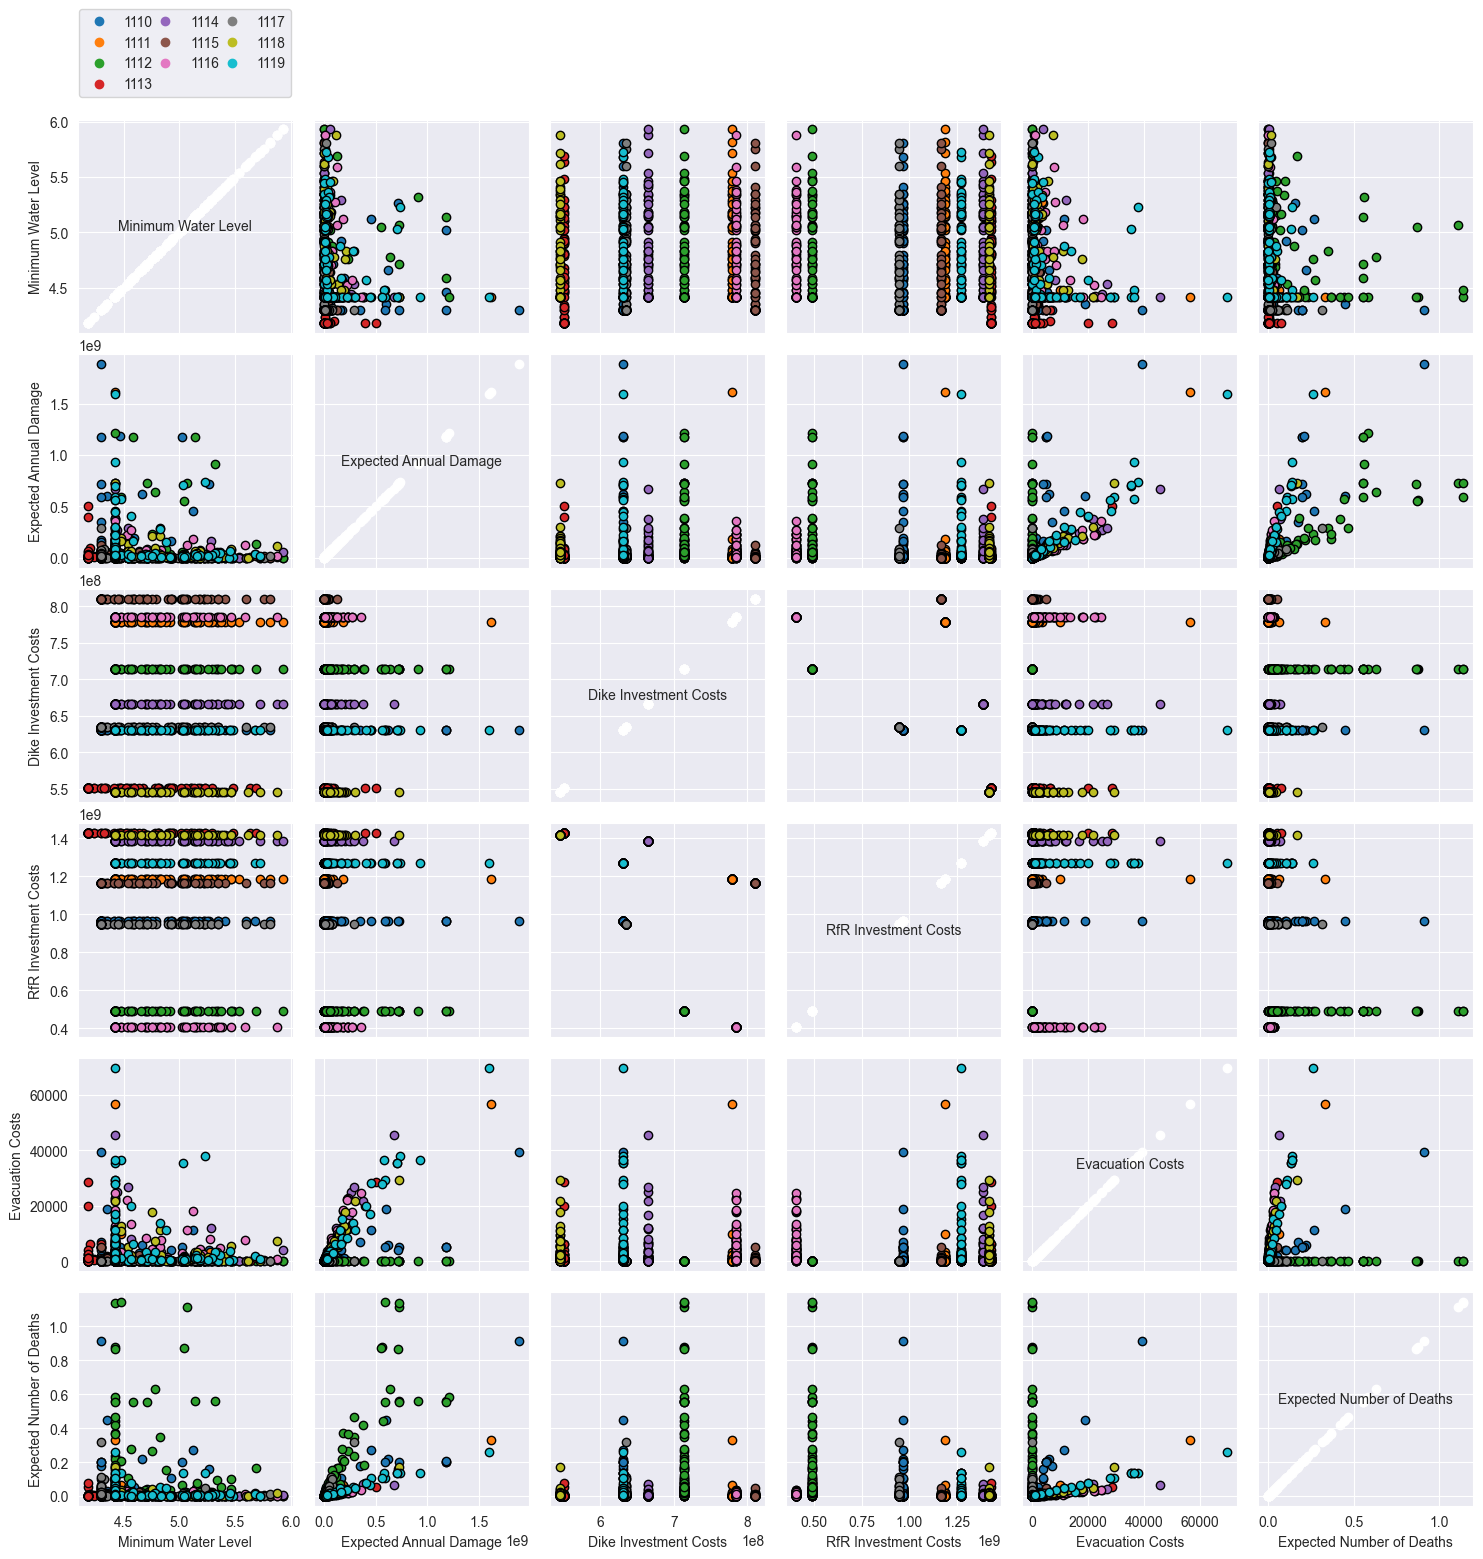

In [24]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes,group_by='policy', legend=True, figsize=(10, 10))
fig.set_size_inches(18, 18)
plt.show()

In [25]:
from ema_workbench import save_results
save_results(results, 'results_ 100 scenarios_10 policies.tar.gz')

[MainProcess/INFO] results saved successfully to /Users/amaryllisbrosens/PycharmProjects/MBDM-Group-1/results_ 100 scenarios_10 policies.tar.gz


### Selected policies - Amaryllis
Now, we are going to test several policies that were discussed during the first debate. Analyzing these policies will provide us a first big picture of the system.

The policies that will be studied are: 

0. Business as usual (BAU)

From [problem_formulation](problem_formulation.py) 's default:
1. policy 1 is about extra protection in upper boundary
2. policy 2 is about extra protection in lower boundary
3. policy 3 is extra protection in random locations

From the first debate: 

4. Room for the River in Doesburg (A1) and Zuthpen (A3)
5. Room for the River in  Doesburg (A1) and Zuthpen (A3) + dike heightening of 5 meters in Cortenoever (A2) and Gorssel (A4) in time decision 0


#TODO add policies with different time decision, right now everthing is at 0.

Outcome of this section: which are the best policies only focusing on water level

In [26]:
#TODO add policies with different time decision, right now everthing is at 0.


In [27]:

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_open_exp = [
        Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "RfR and DH in A1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR and DH in A5",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR in A1, A2, A3 and DH in A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "RfR in A1 and A3 and DH in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 1, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 0, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0}))
]

In [28]:
# NEW POLICIES WITH TIME
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies_open_exp = [
        Policy(
        "P0 BAU",
        **dict(
            get_do_nothing_dict()
        )
    ),
    Policy(
        "RfR and DH in A1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR and DH in A5",
        **dict(
            get_do_nothing_dict(),
            **{"4_RfR 0": 1, "4_RfR 1": 1, "4_RfR 2": 1, "A.5_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "RfR in A1, A2, A3 and DH in A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 1": 1, "3_RfR 2": 1, "A.3_DikeIncrease 0": 5}
        )
    ),
    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

        #RFR in Zuthpen
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 0, "1_RfR 1": 0, "1_RfR 2": 0,
               "3_RfR 0": 1, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

        #RFR in Doesburg
    Policy(
        "RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 0, "3_RfR 1": 0, '3_RfR 2': 0,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "RfR in A1 and A3 and DH in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 1, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 1, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 5, "2_DikeIncrease 1": 0, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0})),

    #RFR in Doesburg and Zuthpen as they talked about in the debate
    Policy(
        "TIME RfR in A1 and A3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 1,
               "3_RfR 0": 0, "3_RfR 1": 1, '3_RfR 2': 1,}
        )
    ),

#RFR in Doesburg and Zuthpen and dike heightening in Cortenoever and Gorssel
     Policy(
        "TIME RfR in A1 and A3 and DH in A2 and A4",
        **dict(
            get_do_nothing_dict(),
            **{# RfR for A1
            "1_RfR 0": 0, "1_RfR 1": 1, "1_RfR 2": 1,
            # RfR for A3
            "3_RfR 0": 0, "3_RfR 1": 1, "3_RfR 2": 1,
            # DikeIncrease for A2
            "2_DikeIncrease 0": 0, "2_DikeIncrease 1": 5, "2_DikeIncrease 2": 0,
            # DikeIncrease for A4
            "4_DikeIncrease 0": 5, "4_DikeIncrease 1": 0, "4_DikeIncrease 2": 0}))

]

In [29]:

# pass the policies list to EMA workbench experiment runs
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_open_exp)



[MainProcess/INFO] pool started with 14 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [01:54<00:00, 87.50it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [30]:
experiments, outcomes = results

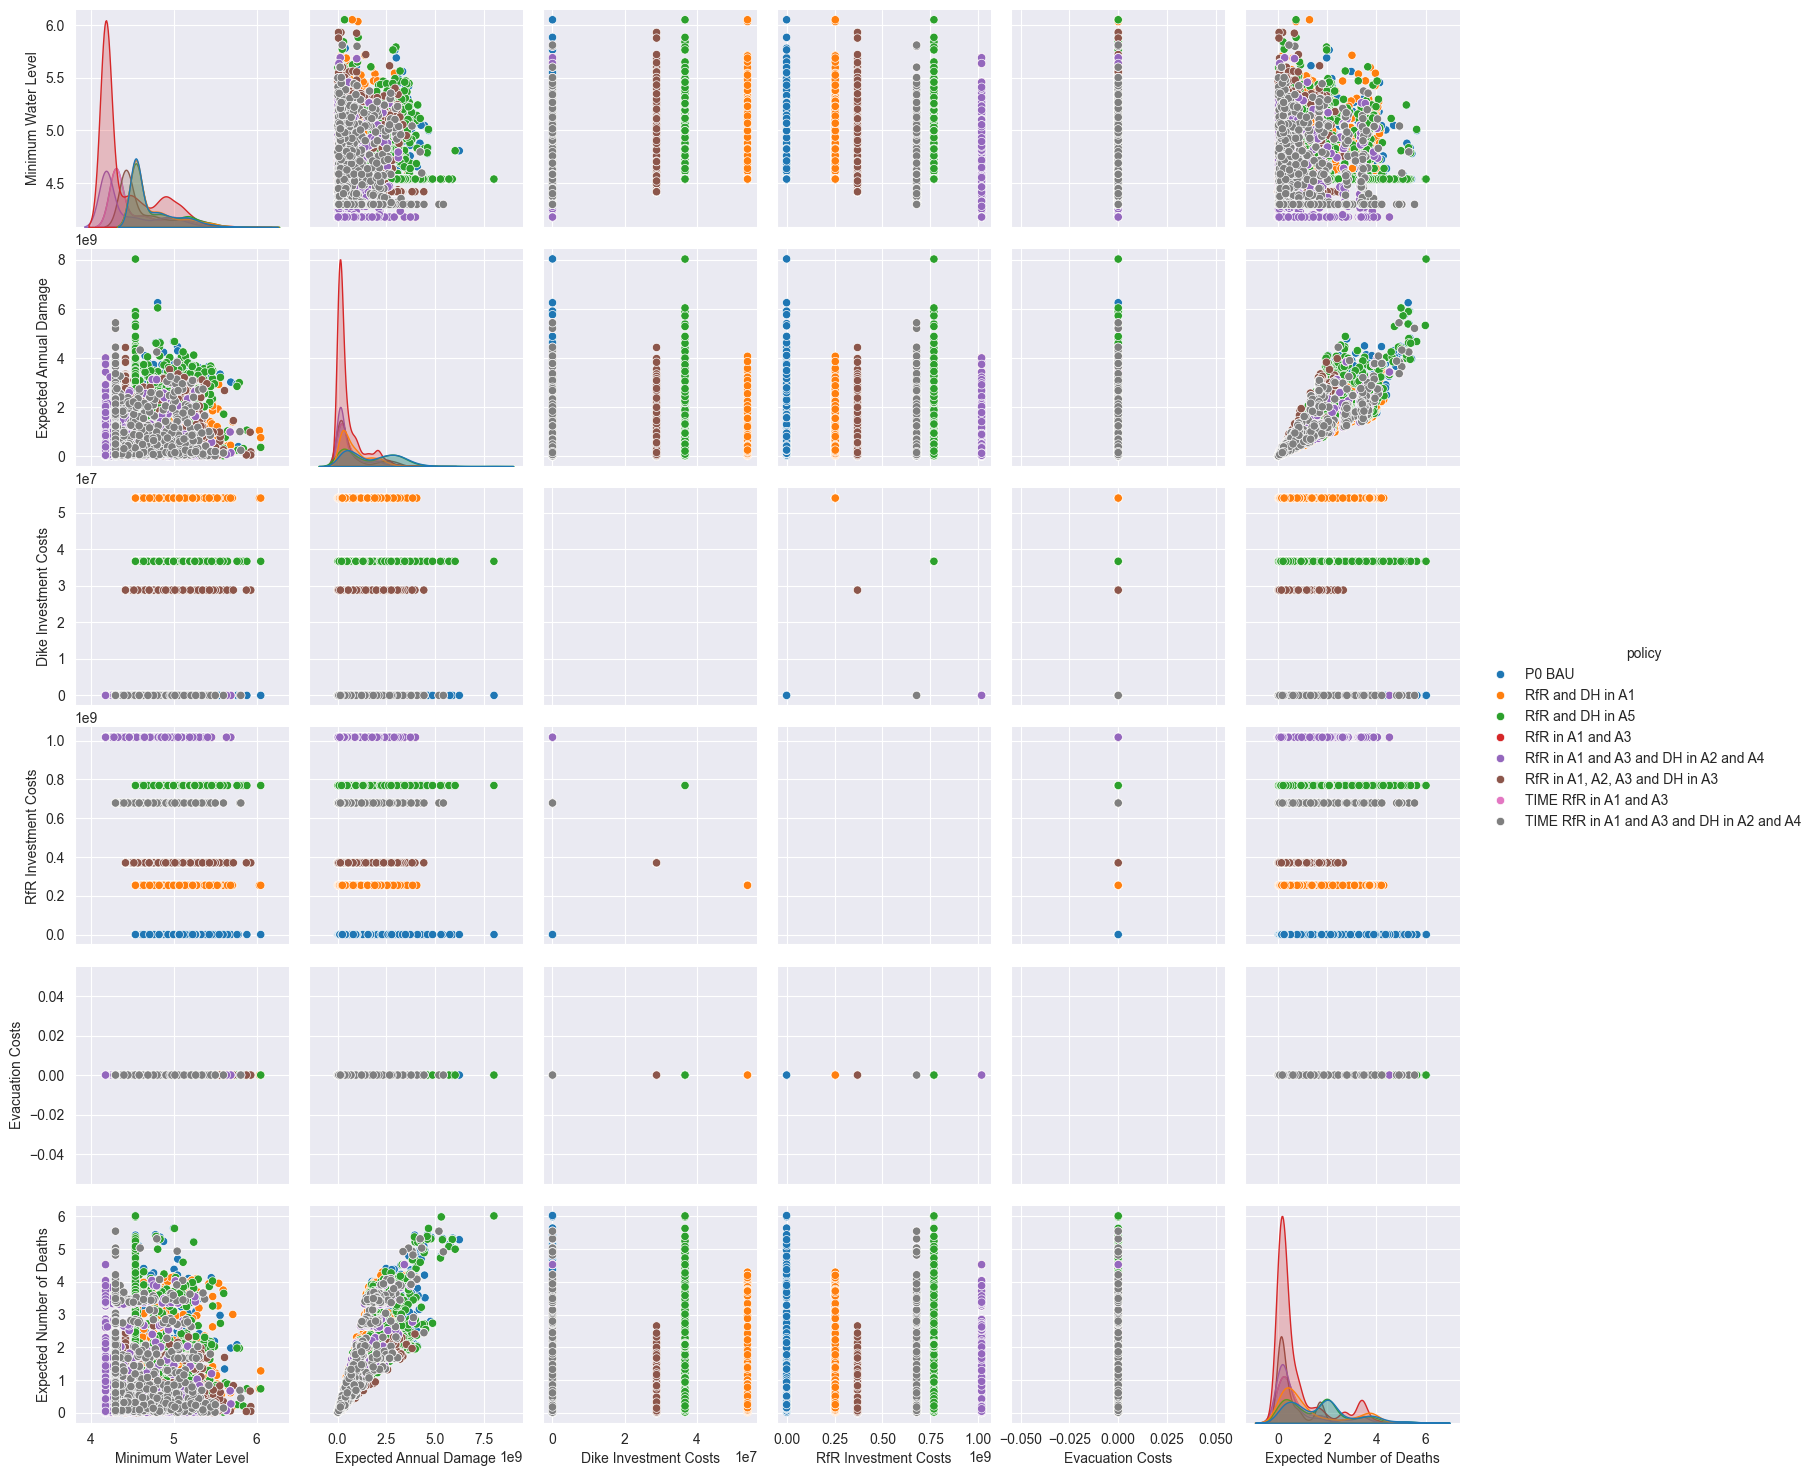

In [31]:
policies_open_exp_2 = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies_open_exp_2

sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
fig1 = plt.gcf()
plt.show()
fig1.savefig("Open exploration policies's outcome vs outcome BAU")

In [32]:
experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                       int64
0_RfR 1                       int64
0_RfR 2                       int64
1_RfR 0                       int64
1_RfR 1                       int64
1_RfR 2                       int64
2_RfR 0                       int64
2_RfR 1                       int64
2_RfR 2                     

In [33]:
#RfR should be 0 or 1, so we can convert it to boolean
for col in experiments.columns:
    if 'RfR' in col:
        experiments[col] = experiments[col].astype(bool)

# Dike heightening should float
for col in experiments.columns:
    if 'DikeIncrease' in col:
        experiments[col] = experiments[col].astype(float)

experiments.dtypes

A.0_ID flood wave shape       int64
A.1_Bmax                    float64
A.1_Brate                  category
A.1_pfail                   float64
A.2_Bmax                    float64
A.2_Brate                  category
A.2_pfail                   float64
A.3_Bmax                    float64
A.3_Brate                  category
A.3_pfail                   float64
A.4_Bmax                    float64
A.4_Brate                  category
A.4_pfail                   float64
A.5_Bmax                    float64
A.5_Brate                  category
A.5_pfail                   float64
discount rate 0            category
discount rate 1            category
discount rate 2            category
0_RfR 0                        bool
0_RfR 1                        bool
0_RfR 2                        bool
1_RfR 0                        bool
1_RfR 1                        bool
1_RfR 2                        bool
2_RfR 0                        bool
2_RfR 1                        bool
2_RfR 2                     

In [34]:
outcomes_df = pd.DataFrame(outcomes)

experiments_df = pd.DataFrame(experiments)

cleaned_experiments = experiments_df.drop(labels=[l.name for l in dike_model.levers], axis=1)

## 2. PRIM - Amaryllis

### Random policies against MWL

In [50]:
# === Define target for PRIM ===
target = (
    (outcomes['Minimum Water Level'] < 4.5) )

In [58]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(random_experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()

AssertionError: 

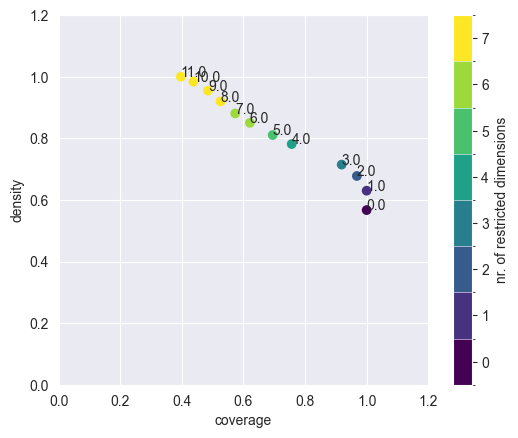

In [57]:
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

In [53]:
#With cleaned experiments
prim_alg = prim.Prim(random_cleaned_experiments, target, threshold=0.75)

box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 1000 points remaining, containing 567 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.207, coverage: 0.36507936507936506, density: 1.0 restricted_dimensions: 8


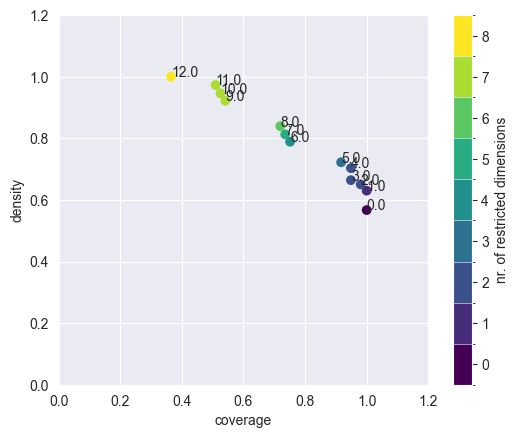

In [54]:
box1.show_tradeoff(annotated =True)
plt.show()

### Random policies against MWL + other stakeholder interests

In [60]:
import numpy as np

# Define the percentile threshold (e.g., 80th percentile = worst 20%)
percentile = 0.8
n = len(outcomes)

# Compute the cutoff values for each variable
death_cutoff = np.sort(outcomes['Expected Number of Deaths'])[int(percentile * n)]
damage_cutoff = np.sort(outcomes['Expected Annual Damage'])[int(percentile * n)]
evac_cost_cutoff = np.sort(outcomes['Evacuation Costs'])[int(percentile * n)]
rfr_cost_cutoff = np.sort(outcomes['RfR Investment Costs'])[int(percentile * n)]
dike_cost_cutoff = np.sort(outcomes['Dike Investment Costs'])[int(percentile * n)]

# Combine into a single boolean target for PRIM
target = (
    (outcomes['Minimum Water Level'] < 4.5) &
    (
        (outcomes['Expected Number of Deaths'] > death_cutoff) |
        (outcomes['Expected Annual Damage'] > damage_cutoff) |
        (outcomes['Evacuation Costs'] > evac_cost_cutoff) |
        (outcomes['RfR Investment Costs'] > rfr_cost_cutoff) |
        (outcomes['Dike Investment Costs'] > dike_cost_cutoff)
    )
)

#focussing on scenarios where the water level is too low and at least one other variable is bad

In [61]:
print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

567
1000
[False  True]


In [62]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(random_experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 1000 points remaining, containing 567 cases of interest
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '104.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.225, coverage: 0.3968253968253968, density: 1.0 restricted_dimensions: 7


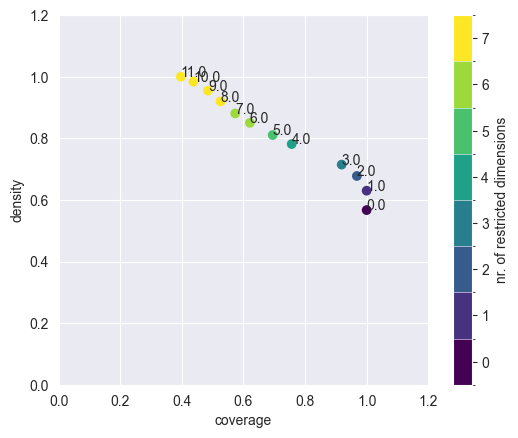

In [63]:
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

In [64]:
#With cleaned experiments
prim_alg = prim.Prim(random_cleaned_experiments, target, threshold=0.75)

box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 1000 points remaining, containing 567 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.207, coverage: 0.36507936507936506, density: 1.0 restricted_dimensions: 8


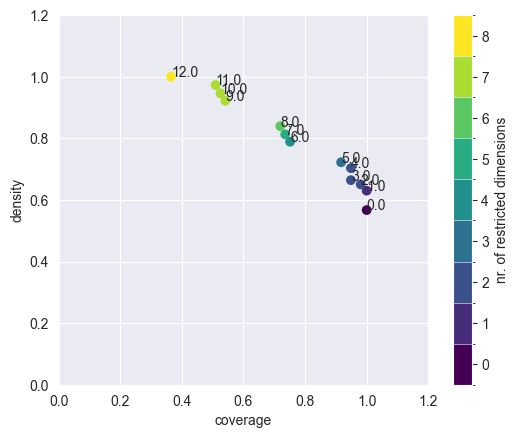

In [65]:
box1.show_tradeoff(annotated =True)
plt.show()

### Selected policies against MWL

In [35]:
# Print all available outcome names
print("Available outcome names:")
for outcome_name in outcomes.keys():
    print(outcome_name)

Available outcome names:
Minimum Water Level
Expected Annual Damage
Dike Investment Costs
RfR Investment Costs
Evacuation Costs
Expected Number of Deaths


In the first iteration we will focus on minimum water level exclusively to identify worst case scenarios

In [36]:
# === Define target for PRIM ===
target = (
    (outcomes['Minimum Water Level'] < 4.5) )

In [37]:
print(target.sum())        # Total number of True values
print(len(target))         # Total number of cases
print(np.unique(target))   # Should be [True, False]

4628
10000
[False  True]


In [38]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()

[MainProcess/INFO] column 2_RfR 0 dropped from analysis because it has only one category
[MainProcess/INFO] column 2_RfR 2 dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 4628 cases of interest
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '105.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '105.5' has dtype i

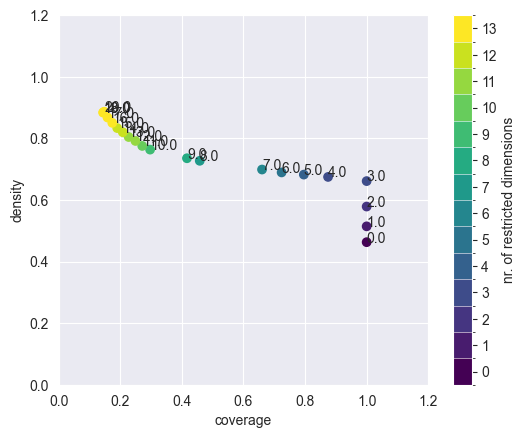

In [39]:
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

In [40]:
from ema_workbench.analysis import prim
#With cleaned experiments


prim_alg = prim.Prim(cleaned_experiments, target, threshold=0.75)


box1 = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 4628 cases of interest
[MainProcess/INFO] mean: 0.9285714285714286, mass: 0.0588, coverage: 0.11797752808988764, density: 0.9285714285714286 restricted_dimensions: 13


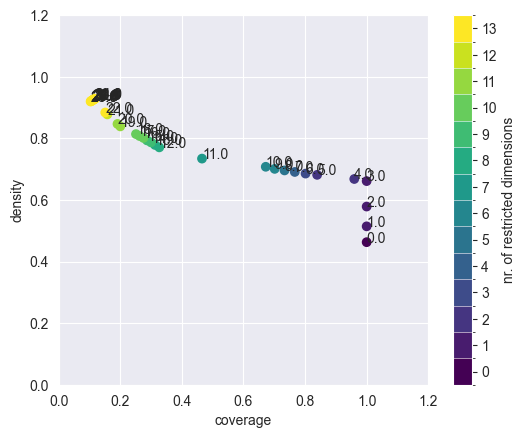

In [41]:
box1.show_tradeoff(annotated =True)
plt.show()

Choose a box that has moderate to high coverage (which means it captures many of the good cases, in this case of the worst-case scenario)
And high density


coverage       0.95981
density        0.66797
id             4.00000
k           4442.00000
mass           0.66500
mean           0.66797
n           6650.00000
res_dim        2.00000
Name: 4, dtype: float64

                                                       box 4  \
                                                         min   
policy     {TIME RfR in A1 and A3, RfR in A1, A2, A3 and ...   
A.2_pfail                                           0.050003   

                                                                             \
                                                         max       qp value   
policy     {TIME RfR in A1 and A3, RfR in A1, A2, A3 and ...  1.006149e-237   
A.2_pfail                                           0.999341   1.222587e-01   

                    
          qp value  
policy         NaN  
A.2_pfail      NaN  



/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'TIME RfR in A1 and A3', 'RfR in A1, A2, A3 and DH in A3', 'RfR in A1 and A3 and DH in A2 and A4', 'RfR in A1 and A3', 'TIME RfR in A1 and A3 and DH in A2 and A4'}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  box_lim.loc[unc] = values.values.tolist() + qp_values[unc]
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:501: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '{'TIME RfR in A1 and A3', 'RfR in A1, A2, A3 and DH in A3', 'RfR in A1 and A3 and DH in A2 and A4', 'RfR in A1 and A3', 'TIME RfR in A1 and A3 and DH in A2 and A4'}' has dtype 

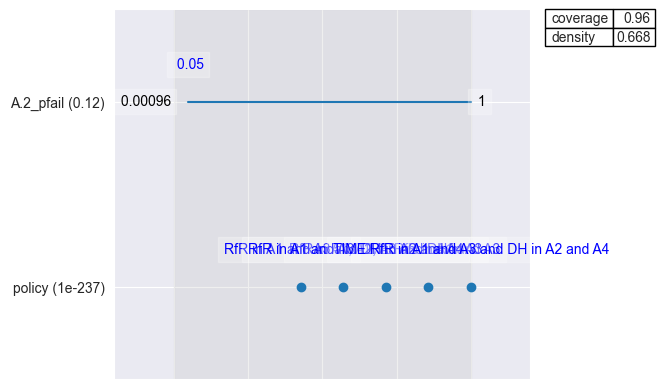

In [42]:
point = 4 # I think 4 or 5

#inspect this box
box1.inspect(point)
box1.inspect(point, style = 'graph')
plt.show()

Here explain the outcomes of the box:
This shows that policy 3, 4 and 5 are bad outcomes for the transport company as the water-level drops below 4.5m. Policy 4 and 5 were considered in the first debate, so this is something the transport company needs to avoid.

Now, we resample to check the robustness of the box. This is done by applying the box's contraints to resampled or shuffled versions of the data. Hereby we can see how much the box's performance was due to overfitting. If the resampled box still shows high coverage and density, the pattern is likely real and stable

In [43]:
box1.resample(point)

[MainProcess/INFO] resample 0
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '127.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

,reproduce coverage,reproduce density
policy,100.0,100.0
A.2_pfail,90.0,50.0
A.2_Bmax,10.0,20.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.1_pfail,0.0,0.0
A.2_Brate,0.0,0.0
A.3_Bmax,0.0,0.0
A.3_Brate,0.0,0.0


What the results of the resampling tells us is that the Policy variable is very robust. This constraint is always part of high-performing boxes in resampled data. This confirms the highly significant quasi p-values in the previous figure. Rest is not robust I think, so the other variables can be safely ignored when interpreting the results.

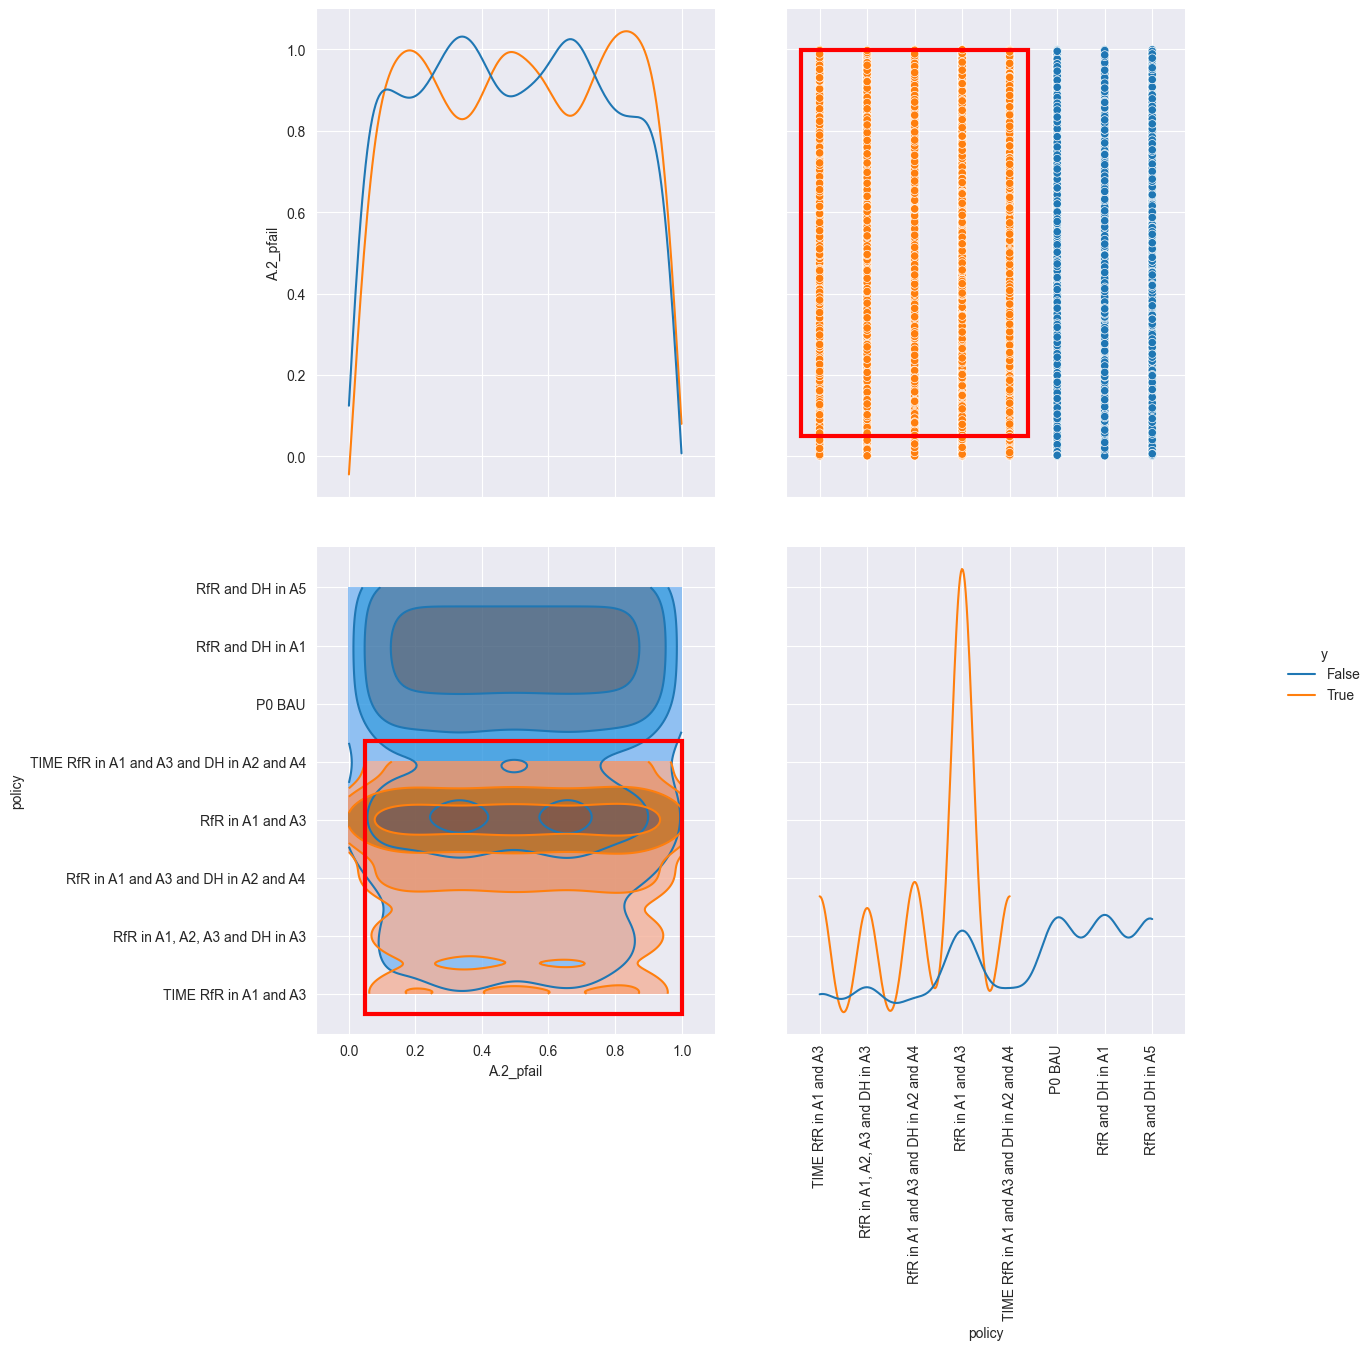

In [44]:
box1.select(point)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

The pair-wise scatterplot shows in orange the cases of interest and in blue the cases of not interest. The red square indicates the identified box limits for each pair of parameters.

In the next step, the results are visualized using dimensional stacking.

[MainProcess/INFO] model dropped from analysis because only a single category
/Users/amaryllisbrosens/Downloads/epa141A_open-master/.venv/lib/python3.13/site-packages/ema_workbench/analysis/dimensional_stacking.py:408: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pvt = pd.pivot_table(x_y_concat, values=ooi_label, index=rows, columns=columns, dropna=False)


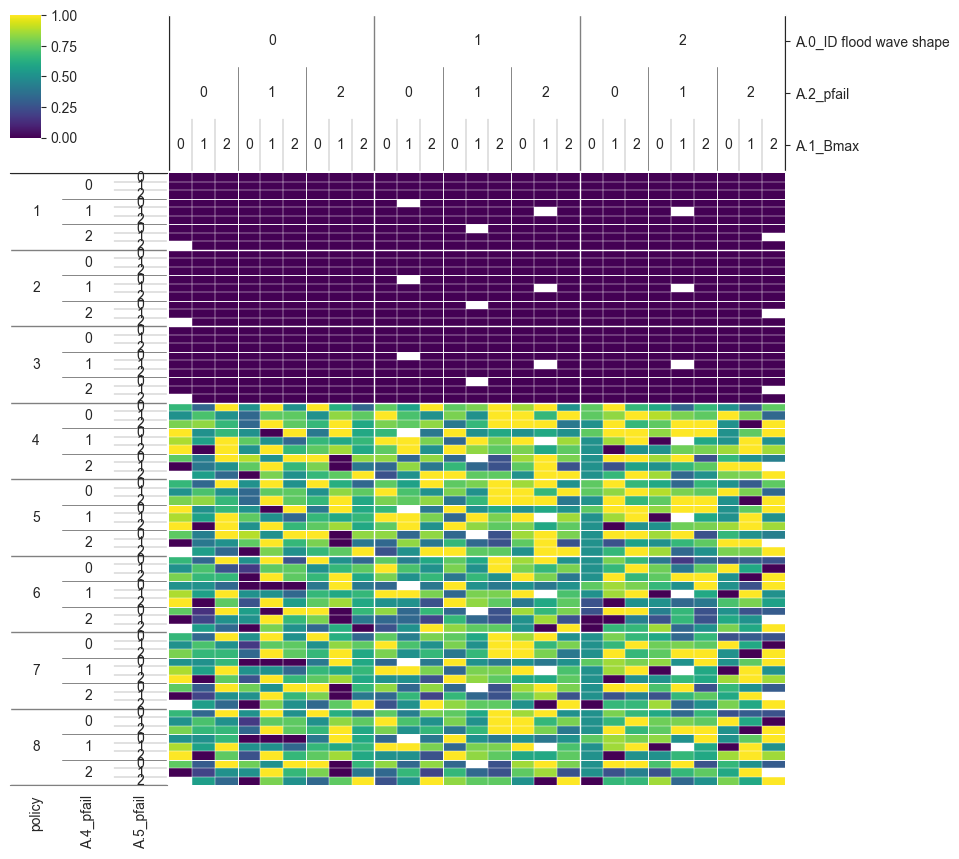

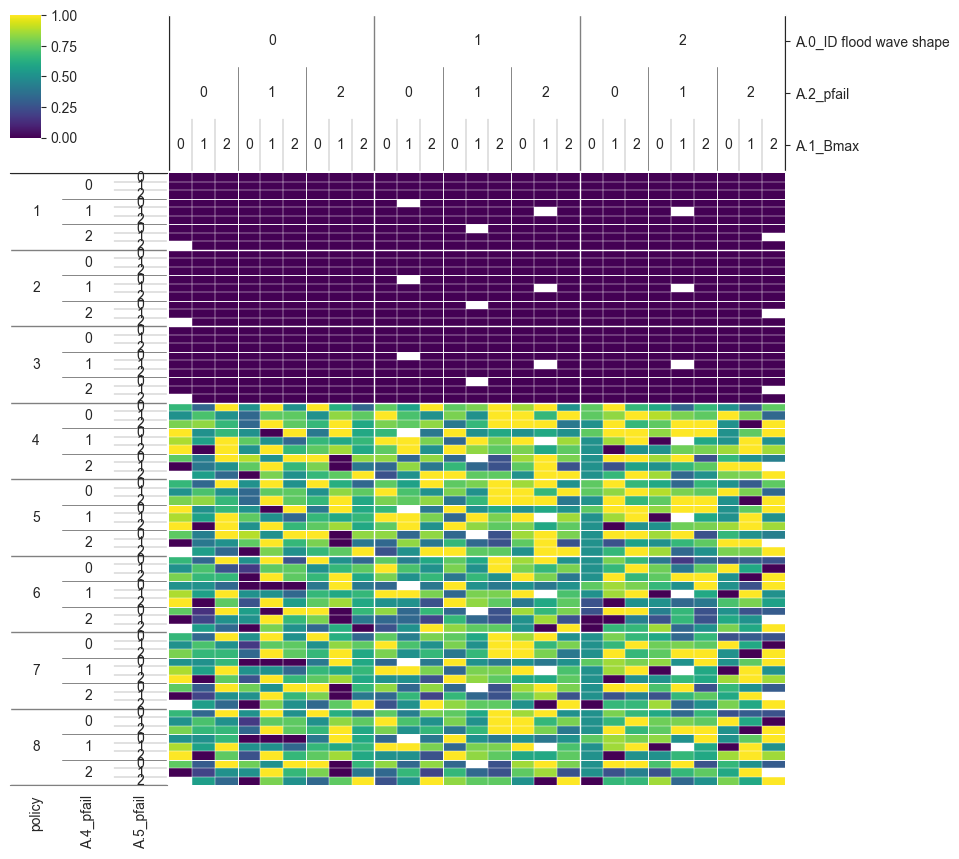

In [45]:
from ema_workbench.analysis import dimensional_stacking
dimensional_stacking.create_pivot_plot(cleaned_experiments, target)

### Selected policies against MWL + other stakeholders'interests

In [ ]:
import numpy as np

# Define the percentile threshold (e.g., 80th percentile = worst 20%)
percentile = 0.8
n = len(outcomes)

# Compute the cutoff values for each variable
death_cutoff = np.sort(outcomes['Expected Number of Deaths'])[int(percentile * n)]
damage_cutoff = np.sort(outcomes['Expected Annual Damage'])[int(percentile * n)]
evac_cost_cutoff = np.sort(outcomes['Evacuation Costs'])[int(percentile * n)]
rfr_cost_cutoff = np.sort(outcomes['RfR Investment Costs'])[int(percentile * n)]
dike_cost_cutoff = np.sort(outcomes['Dike Investment Costs'])[int(percentile * n)]

# Combine into a single boolean target for PRIM
target = (
        (outcomes['Minimum Water Level'] < 4.5) &
        (
                (outcomes['Expected Number of Deaths'] > death_cutoff) |
                (outcomes['Expected Annual Damage'] > damage_cutoff) |
                (outcomes['Evacuation Costs'] > evac_cost_cutoff) |
                (outcomes['RfR Investment Costs'] > rfr_cost_cutoff) |
                (outcomes['Dike Investment Costs'] > dike_cost_cutoff)
        )
)

#focussing on scenarios where the water level is too low and at least one other variable is bad

In [ ]:
print(target.sum())  # Total number of True values
print(len(target))  # Total number of cases
print(np.unique(target))  # Should be [True, False]

In [ ]:
# === Run PRIM without cleaning the experiments===
prim_alg = prim.Prim(experiments_df, target, threshold=0.8, peel_alpha=0.1)
box_raw_experiments = prim_alg.find_box()
box_raw_experiments.show_tradeoff(annotated=True)
plt.show()

In [ ]:
#With cleaned experiments
prim_alg = prim.Prim(cleaned_experiments, target, threshold=0.75)

box1 = prim_alg.find_box()
box1.show_tradeoff(annotated=True)
plt.show()

# Other stuff/ questions

- What should we do with the results of BAU?
- Difference between cleaned experiments and experiments in PRIM?
- Why does PRIM make such big jumps? Something with peel_alpha?
- 2_RfR is removed by PRIM as it does not change, what does this mean?


Later: 
- Interpret all graphs together
- Write our pretty report